In [40]:
import datetime
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from func.tide import get_dates
from tech.psar import (
    calc_PSAR,
    calc_PSAR0,
    initialize,
)

### 収集対象の日

In [41]:
target='2024-12-27'
start, end = get_dates(target)

### 対象銘柄

In [42]:
code = '8306'

### yfinance で１分足のデータを収集

In [43]:
symbol = '%s.T' % code
ticker = yf.Ticker(symbol)

df = ticker.history(period='1d', interval='1m', start=start, end=end)
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-12-27 09:05:00+09:00,1827.5,1829.0,1826.0,1826.0,0,0.0,0.0
2024-12-27 09:06:00+09:00,1826.0,1829.0,1825.5,1828.5,155400,0.0,0.0
2024-12-27 09:07:00+09:00,1829.0,1832.5,1828.0,1829.5,375300,0.0,0.0
2024-12-27 09:08:00+09:00,1830.0,1831.5,1829.0,1829.5,125800,0.0,0.0
2024-12-27 09:09:00+09:00,1829.0,1831.0,1828.0,1831.0,237900,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-27 15:20:00+09:00,1826.5,1827.0,1824.5,1825.0,263700,0.0,0.0
2024-12-27 15:21:00+09:00,1825.0,1825.5,1824.0,1824.5,271300,0.0,0.0
2024-12-27 15:22:00+09:00,1825.0,1826.0,1824.5,1824.5,132900,0.0,0.0


### 時間情報のタイムゾーン部分を削除

In [44]:
name_index = df.index.name
df.index = [ts_jst.tz_localize(None) for ts_jst in df.index]
df.index.name = name_index
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-12-27 09:05:00,1827.5,1829.0,1826.0,1826.0,0,0.0,0.0
2024-12-27 09:06:00,1826.0,1829.0,1825.5,1828.5,155400,0.0,0.0
2024-12-27 09:07:00,1829.0,1832.5,1828.0,1829.5,375300,0.0,0.0
2024-12-27 09:08:00,1830.0,1831.5,1829.0,1829.5,125800,0.0,0.0
2024-12-27 09:09:00,1829.0,1831.0,1828.0,1831.0,237900,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-27 15:20:00,1826.5,1827.0,1824.5,1825.0,263700,0.0,0.0
2024-12-27 15:21:00,1825.0,1825.5,1824.0,1824.5,271300,0.0,0.0
2024-12-27 15:22:00,1825.0,1826.0,1824.5,1824.5,132900,0.0,0.0


### 前場と後場の間に（なぜか）余分なデータが含まれているので削除

In [45]:
date_str = str(df.index[0].date())
dt_lunch_1 = pd.to_datetime('%s 11:30:00' % date_str)
dt_lunch_2 = pd.to_datetime('%s 12:30:00' % date_str)
df1 = df[df.index <= dt_lunch_1]
df2 = df[dt_lunch_2 <= df.index]
df = pd.concat([df1, df2])
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-12-27 09:05:00,1827.5,1829.0,1826.0,1826.0,0,0.0,0.0
2024-12-27 09:06:00,1826.0,1829.0,1825.5,1828.5,155400,0.0,0.0
2024-12-27 09:07:00,1829.0,1832.5,1828.0,1829.5,375300,0.0,0.0
2024-12-27 09:08:00,1830.0,1831.5,1829.0,1829.5,125800,0.0,0.0
2024-12-27 09:09:00,1829.0,1831.0,1828.0,1831.0,237900,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-27 15:20:00,1826.5,1827.0,1824.5,1825.0,263700,0.0,0.0
2024-12-27 15:21:00,1825.0,1825.5,1824.0,1824.5,271300,0.0,0.0
2024-12-27 15:22:00,1825.0,1826.0,1824.5,1824.5,132900,0.0,0.0


In [46]:
df = initialize(df)
for i in range(len(df)):
    if i == 1:
        calc_PSAR0(df, i)
    elif i > 1:
        calc_PSAR(df, i)
print(df)

                       Open    High     Low   Close  Volume  Trend      EP  \
Datetime                                                                     
2024-12-27 09:05:00  1827.5  1829.0  1826.0  1826.0       0    NaN     NaN   
2024-12-27 09:06:00  1826.0  1829.0  1825.5  1828.5  155400    1.0  1829.0   
2024-12-27 09:07:00  1829.0  1832.5  1828.0  1829.5  375300   -1.0  1832.5   
2024-12-27 09:08:00  1830.0  1831.5  1829.0  1829.5  125800    1.0  1832.5   
2024-12-27 09:09:00  1829.0  1831.0  1828.0  1831.0  237900   -1.0  1828.0   
...                     ...     ...     ...     ...     ...    ...     ...   
2024-12-27 15:20:00  1826.5  1827.0  1824.5  1825.0  263700    1.0  1827.0   
2024-12-27 15:21:00  1825.0  1825.5  1824.0  1824.5  271300    1.0  1827.0   
2024-12-27 15:22:00  1825.0  1826.0  1824.5  1824.5  132900    1.0  1827.0   
2024-12-27 15:23:00  1824.5  1828.0  1824.5  1827.5  403900    1.0  1828.0   
2024-12-27 15:24:00  1826.5  1828.0  1825.5  1827.0  324500    1

In [47]:
df['bull'] = df[df['Trend'] == 1]['PSAR']
df['bear'] = df[df['Trend'] == -1]['PSAR']
df

,Open,High,Low,Close,Volume,Trend,EP,AF,PSAR,bull,bear
Datetime,,,,,,,,,,,
2024-12-27 09:05:00,1827.5,1829.0,1826.0,1826.0,0,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-27 09:06:00,1826.0,1829.0,1825.5,1828.5,155400,1.0,1829.0,0.02,1829.000000,1829.000000,NaN
2024-12-27 09:07:00,1829.0,1832.5,1828.0,1829.5,375300,-1.0,1832.5,0.02,1829.000000,NaN,1829.0
2024-12-27 09:08:00,1830.0,1831.5,1829.0,1829.5,125800,1.0,1832.5,0.02,1832.500000,1832.500000,NaN
2024-12-27 09:09:00,1829.0,1831.0,1828.0,1831.0,237900,-1.0,1828.0,0.02,1832.500000,NaN,1832.5
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27 15:20:00,1826.5,1827.0,1824.5,1825.0,263700,1.0,1827.0,0.06,1820.043594,1820.043594,NaN
2024-12-27 15:21:00,1825.0,1825.5,1824.0,1824.5,271300,1.0,1827.0,0.06,1820.460978,1820.460978,NaN
2024-12-27 15:22:00,1825.0,1826.0,1824.5,1824.5,132900,1.0,1827.0,0.06,1820.853320,1820.853320,NaN


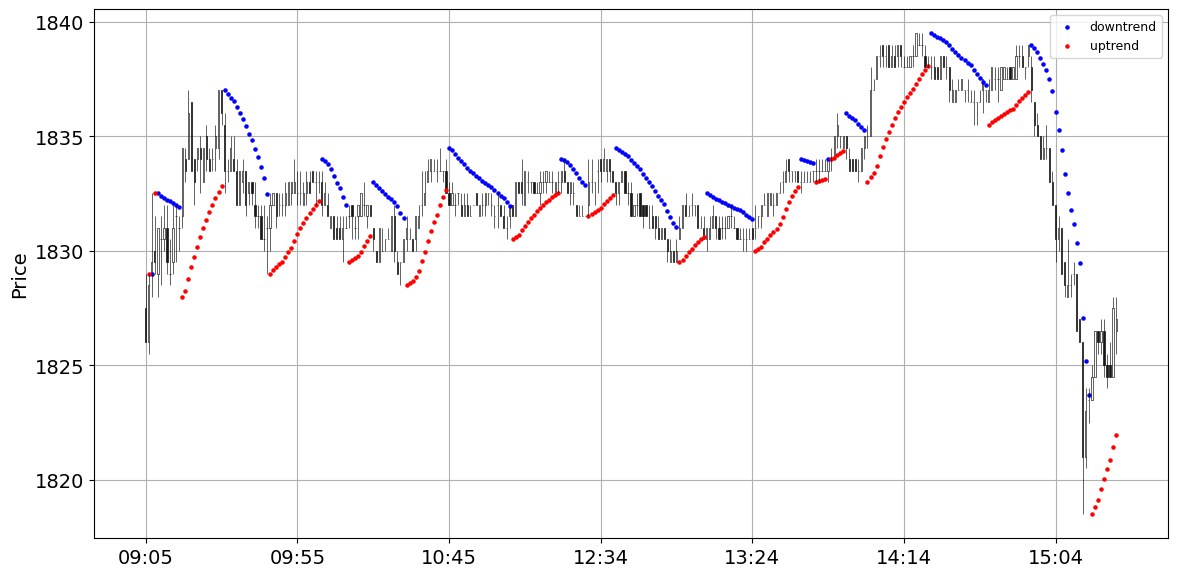

In [52]:
plt.rcParams["font.size"] = 14
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        df['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        df['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    volume=False,
    datetime_format='%H:%M',
    addplot=apds,
    xrotation=0,
    ax=ax,
)

ax.grid()
ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.show()